In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Mis modulos
from src.graficar import graficar_serie

# Pythorch
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.optim as optim

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [182]:
ruta = 'data/clean_data/nasdaq.csv'
serie = pd.read_csv(ruta, names = ['Valores'])
serie.head()

,Valores
0,459.33
1,460.90
2,459.39
3,458.22
4,458.71


### Vamos a diferenciar la serie porque la original no dio buenos resultados

In [183]:
s = serie['Valores']
# Difereniación simple
diff = s.diff().diff().dropna()
primeros_valores = s.iloc[:2]

print(f'Primer valor de la serie original: \n{np.round(primeros_valores, 4)}')
print(diff.head())

Primer valor de la serie original: 
0    459.33
1    460.90
Name: Valores, dtype: float64
2   -3.08
3    0.34
4    1.66
5   -2.43
6   -4.13
Name: Valores, dtype: float64


### Validación de la serie usando Data Loader

In [184]:
def crear_ventanas(diff, ventana):
    X, y = [], []
    for i in range(len(diff) - ventana):
        X.append(diff[i : i + ventana])
        y.append(diff[i + ventana])
    return np.array(X), np.array(y)

In [185]:
ventana = 100
X, y = crear_ventanas(diff.values, ventana)

# Proporciones para conjuntos
n = len(X)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

# Respetar la dependencia temporal
X_train = X[:train_end]
y_train = y[:train_end]

X_val = X[train_end:val_end]
y_val = y[train_end:val_end]

X_test = X[val_end:]
y_test = y[val_end:]

# Trabajar con tensores
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val   = torch.tensor(X_val,   dtype=torch.float32).unsqueeze(1)
X_test  = torch.tensor(X_test,  dtype=torch.float32).unsqueeze(1)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_val   = torch.tensor(y_val,   dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.float32)

# Crear los Datasets con shuffle = False
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val,   y_val)
test_dataset  = TensorDataset(X_test,  y_test)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)


In [186]:
for xb, yb in train_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([32, 1, 100]) torch.Size([32])


### Estructura de la Red Convolucional para Conv1

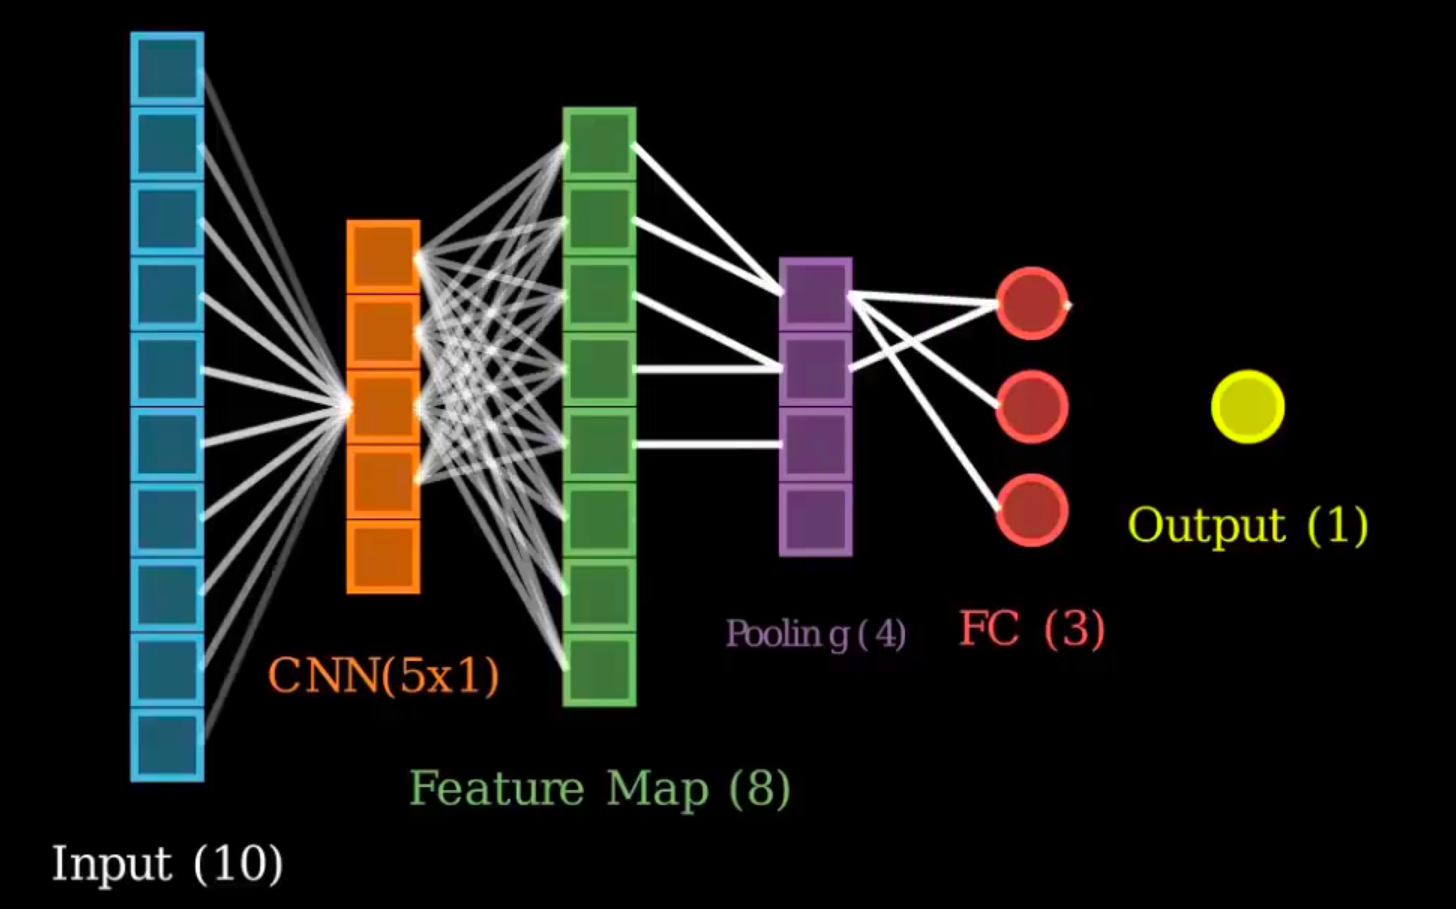

In [ ]:
# Esta no
class Conv1DRegressor(nn.Module):
    def __init__(self, window_size):
        super().__init__()

        self.conv_layers = nn.Sequential(

            # ----- Bloque 1 -----
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),     # 100 → 50

            # ----- Bloque 2 -----
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool1d(2),     # 50 → 25

            # ----- Bloque 3 -----
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool1d(5),     # 25 → 5

            nn.AdaptiveAvgPool1d(1)   # 5 → 1
        )

        # ----- MLP final -----
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)     # (batch, 128, 1)
        x = x.squeeze(-1)           # (batch, 128)
        return self.fc(x)


In [191]:
class Conv1DRegressor(nn.Module):
    def __init__(self, window_size):
        super().__init__()
        self.conv_layers = nn.Sequential(

            # ----- Bloque 1 -----
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),     # 100 → 50

            # ----- Bloque 2 -----
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),     # 50 → 25

            # ----- Bloque 3 -----
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(5),     # 25 → 5

            # ----- Bloque 4 extra (nuevo) -----
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.AdaptiveAvgPool1d(1)   # 5 → 1
        )

        # ----- MLP final -----
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)     # (batch, 256, 1)
        x = x.squeeze(-1)           # (batch, 256)
        return self.fc(x)



In [192]:
model = Conv1DRegressor(window_size=ventana)
print(f'Parámetros totales: {sum(p.numel() for p in model.parameters())}')
# 257505

Parámetros totales: 257505


### Instanciar la Red, Pérdida y Optimizador

In [193]:
# MSE y optimizador
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(),
                       lr=1e-4,
                       weight_decay=1e-4) 

# Ajustar el lr
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5
)

### Función de entrenamiento 

In [194]:
def train_epoch(model, train_loader, criterion, optimizer):
    """Entrena una época completa en CPU"""
    model.train()
    train_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        if batch_idx % 50 == 0:
            print(f'  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.6f}')
    
    return train_loss / len(train_loader)


def validate_epoch(model, val_loader, criterion):
    """Evalúa el modelo en el conjunto de validación en CPU"""
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = criterion(output, target.unsqueeze(1))
            val_loss += loss.item()
    
    return val_loss / len(val_loader)

In [195]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                scheduler, epochs=100, patience=15):
    """
    Entrena el modelo con early stopping (CPU)
    """
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        print(f'\nÉpoca {epoch+1}/{epochs}')
        print('-' * 40)
        
        # Entrenar
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        
        # Validar
        val_loss = validate_epoch(model, val_loader, criterion)
        val_losses.append(val_loss)
        
        print(f'Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
        
        # Ajustar learning rate
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f'Mejor modelo guardado (Val Loss: {val_loss:.6f})')
        else:
            patience_counter += 1
            print(f'Sin mejora ({patience_counter}/{patience})')
            
        if patience_counter >= patience:
            print(f'\nEarly stopping en época {epoch+1}')
            break
    
    # Cargar el mejor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

### Entrenamiento

In [ ]:
epochs = 100
patience = 20

model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=epochs,
    patience=patience
)


Época 1/100
----------------------------------------
  Batch 0/35, Loss: 10.471593
Train Loss: 38.131115, Val Loss: 32.733249
Mejor modelo guardado (Val Loss: 32.733249)

Época 2/100
----------------------------------------
  Batch 0/35, Loss: 10.441447
Train Loss: 38.114174, Val Loss: 32.725353
Mejor modelo guardado (Val Loss: 32.725353)

Época 3/100
----------------------------------------
  Batch 0/35, Loss: 10.509953
Train Loss: 38.083638, Val Loss: 32.731184
Sin mejora (1/20)

Época 4/100
----------------------------------------
  Batch 0/35, Loss: 10.407654
Train Loss: 38.059261, Val Loss: 32.730264
Sin mejora (2/20)

Época 5/100
----------------------------------------
  Batch 0/35, Loss: 10.393125
Train Loss: 38.051590, Val Loss: 32.738164
Sin mejora (3/20)

Época 6/100
----------------------------------------
  Batch 0/35, Loss: 10.553808
Train Loss: 38.006733, Val Loss: 32.736688
Sin mejora (4/20)

Época 7/100
----------------------------------------
  Batch 0/35, Loss: 10.5

### Visualizar resultados entrenamiento

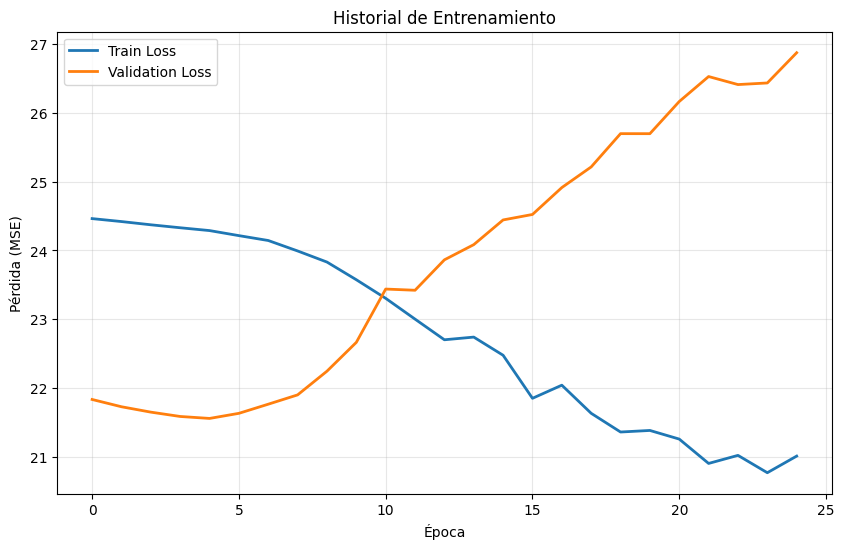

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.xlabel('Época')
    plt.ylabel('Pérdida (MSE)')
    plt.title('Historial de Entrenamiento')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_training_history(train_losses, val_losses)

### Evaluar en Test

In [ ]:
## Ahorita no
def evaluate_model(model, test_loader, criterion, last_value):
    """
    Evalúa el modelo en diferencias y reconstruye la serie
    para evaluación en la escala original.
    """
    model.eval()
    test_loss = 0.0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for X, y in test_loader:
            pred = model(X)
            loss = criterion(pred, y.unsqueeze(1))
            test_loss += loss.item()

            predictions.extend(pred.numpy().flatten())
            targets.extend(y.numpy())

    test_loss /= len(test_loader)
    predictions = np.array(predictions)
    targets = np.array(targets)
    
    # Métricas en diferencias
    mae_diff = mean_absolute_error(targets, predictions)
    r2_diff  = r2_score(targets, predictions)
    rmse_diff = np.sqrt(test_loss)

    print("\n===== EVALUACIÓN (ESCALA DIFERENCIADA) =====")
    print(f"  MSE :  {test_loss:.4f}")
    print(f"  RMSE: {rmse_diff:.4f}")
    print(f"  MAE : {mae_diff:.4f}")
    print(f"  R²  : {r2_diff:.4f}")

    # ---------- Reconstrucción 1 diff----------
    def reconstruct(diff_values, start_value):
        result = [start_value]
        for d in diff_values:
            result.append(result[-1] + d)
        return np.array(result[1:])

    pred_recon = reconstruct(predictions, last_value)
    target_recon = reconstruct(targets, last_value)


    # Métricas en escala real
    mse_real = mean_squared_error(target_recon, pred_recon)
    mae_real = mean_absolute_error(target_recon, pred_recon)
    r2_real  = r2_score(target_recon, pred_recon)
    rmse_real = np.sqrt(mse_real)

    print("\n===== EVALUACIÓN (ESCALA ORIGINAL) =====")
    print(f"  MSE :  {mse_real:.4f}")
    print(f"  RMSE: {rmse_real:.4f}")
    print(f"  MAE : {mae_real:.4f}")
    print(f"  R²  : {r2_real:.4f}")
    
    return (predictions, targets, pred_recon, target_recon)


In [ ]:
def evaluate_model(model, test_loader, criterion, last_value):
    """
    Evalúa el modelo en diferencias y reconstruye la serie
    para evaluación en la escala original.
    """
    model.eval()
    test_loss = 0.0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for X, y in test_loader:
            pred = model(X)
            loss = criterion(pred, y.unsqueeze(1))
            test_loss += loss.item()

            predictions.extend(pred.numpy().flatten())
            targets.extend(y.numpy())

    test_loss /= len(test_loader)
    predictions = np.array(predictions)
    targets = np.array(targets)
    
    # Métricas en diferencias
    mae_diff = mean_absolute_error(targets, predictions)
    r2_diff  = r2_score(targets, predictions)
    rmse_diff = np.sqrt(test_loss)

    print("\n===== EVALUACIÓN (ESCALA DIFERENCIADA) =====")
    print(f"  MSE :  {test_loss:.4f}")
    print(f"  RMSE: {rmse_diff:.4f}")
    print(f"  MAE : {mae_diff:.4f}")
    print(f"  R²  : {r2_diff:.4f}")

    # ---------- Reconstrucción 2 diff----------
    def reconstruct(diff2_values, s0, s1):
        # 1) reconstruimos la primera diferencia
        diff1 = [s1 - s0]   # primera diferencia inicial
        
        for d2 in diff2_values:
            diff1.append(diff1[-1] + d2)
        
        diff1 = np.array(diff1)
        
        # 2) reconstruimos la serie original
        s = [s0]
        for d1 in diff1:
            s.append(s[-1] + d1)
        
        # quitamos el primer elemento (solo era inicial)
        return np.array(s[1:])

    pred_recon = reconstruct(predictions, last_value)
    target_recon = reconstruct(targets, last_value)


    # Métricas en escala real
    mse_real = mean_squared_error(target_recon, pred_recon)
    mae_real = mean_absolute_error(target_recon, pred_recon)
    r2_real  = r2_score(target_recon, pred_recon)
    rmse_real = np.sqrt(mse_real)

    print("\n===== EVALUACIÓN (ESCALA ORIGINAL) =====")
    print(f"  MSE :  {mse_real:.4f}")
    print(f"  RMSE: {rmse_real:.4f}")
    print(f"  MAE : {mae_real:.4f}")
    print(f"  R²  : {r2_real:.4f}")
    
    return (predictions, targets, pred_recon, target_recon)


In [170]:
last_value = s.iloc[ train_end + ventana ] # Ultimo valor antes del conjunto de test
pred_diff, target_diff, pred_real, target_real = evaluate_model(
    model, test_loader, criterion, last_value
)


===== EVALUACIÓN (ESCALA DIFERENCIADA) =====
  MSE :  108.4411
  RMSE: 10.4135
  MAE : 8.3355
  R²  : -0.1851

===== EVALUACIÓN (ESCALA ORIGINAL) =====
  MSE :  133999.4142
  RMSE: 366.0593
  MAE : 320.9600
  R²  : -35.4765


### Visualizar predicción vs real

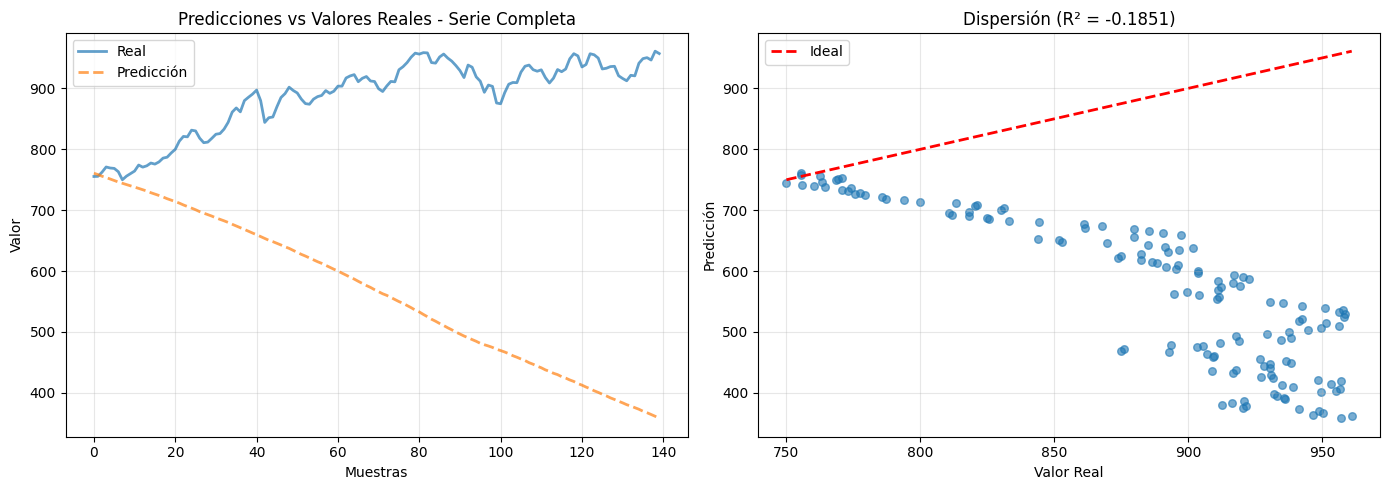

In [175]:
def plot_predictions_vs_real(predictions, targets, title="Predicciones vs Valores Reales"):
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(targets, label='Real', alpha=0.7, linewidth=2)
    plt.plot(predictions, label='Predicción', alpha=0.7, linestyle='--', linewidth=2)
    plt.xlabel('Muestras')
    plt.ylabel('Valor')
    plt.title(f'{title} - Serie Completa')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.scatter(targets, predictions, alpha=0.6, s=30)
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 
             'r--', label='Ideal', linewidth=2)
    plt.xlabel('Valor Real')
    plt.ylabel('Predicción')
    plt.title(f'Dispersión (R² = {r2:.4f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_predictions_vs_real(pred_real, target_real)

### Guardar modelo entrenado

In [142]:
def save_model(model, path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'window_size': ventana,
        'input_shape': (1, ventana)
    }, path)
    print(f'Modelo guardado en {path}')

save_model(model, 'time_series_cnn_model.pth')

Modelo guardado en time_series_cnn_model.pth


### Predicciónes futuras

In [143]:
def predecir_futuro(model, serie, ventana, n_pasos=10):
    model.eval()
    predicciones = []
    
    ultima_ventana = serie[-ventana:].copy()
    
    with torch.no_grad():
        for _ in range(n_pasos):
            x = torch.tensor(ultima_ventana, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            pred = model(x).numpy()[0, 0]
            predicciones.append(pred)
            
            ultima_ventana = np.roll(ultima_ventana, -1)
            ultima_ventana[-1] = pred
    
    return np.array(predicciones)

# Ejemplo:
# predicciones_futuras = predecir_futuro(model, serie.values, ventana, n_pasos=20)